In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import PIL
import scipy
import skimage # 0.16 required

import utils
import utils_camera
import utils_display

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Camera configuration

<IPython.core.display.Javascript object>


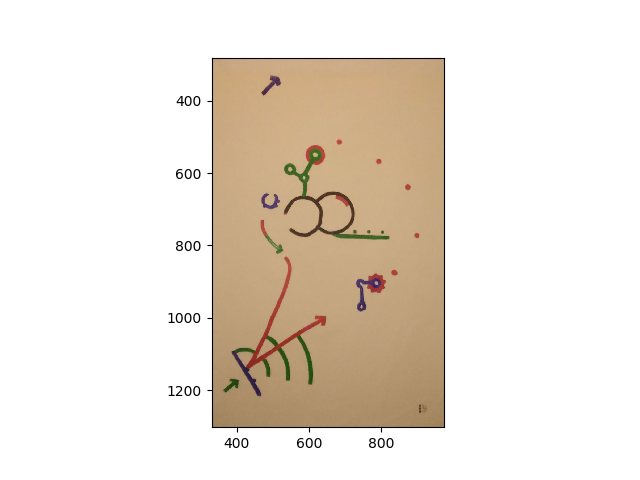

In [2]:
camera_path = '.'
img = utils_camera.get_latest_img(camera_path)
plt.figure()
plt.imshow(img);

### get the right part coordinates

In [3]:
axis = plt.gca()
x_min, x_max, y_min, y_max = utils.get_axis_bounds(axis)


# Stroke configuration

<IPython.core.display.Javascript object>


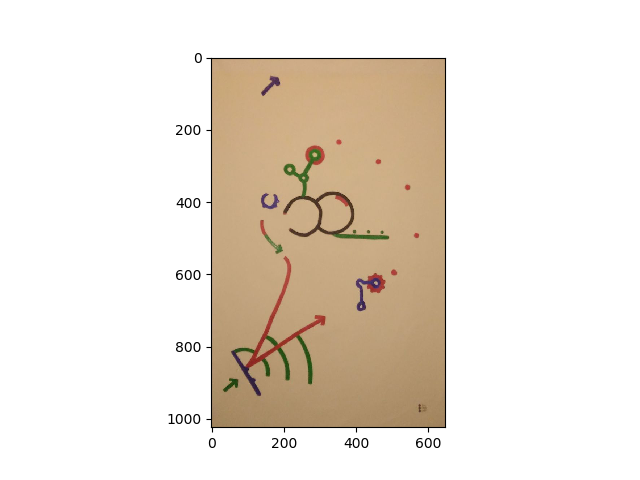

In [4]:
img_np = img[y_min:y_max+1, x_min:x_max+1]

use_mask = False
mask = None
if use_mask :
    mask = np.ones_like(img_np)
    cx, cy = img_np.shape[1]//2, img_np.shape[0]//2
    r = 150
    y, x = np.mgrid[0:img_np.shape[0],0:img_np.shape[1]]
    mask= (((x-cx)**2 + (y-cy)**2) < r**2).astype(img_np.dtype)[:,:,np.newaxis]
    img_np *= mask

plt.figure()
plt.imshow(img_np);

### Define the colors and plot distance histograms

<IPython.core.display.Javascript object>


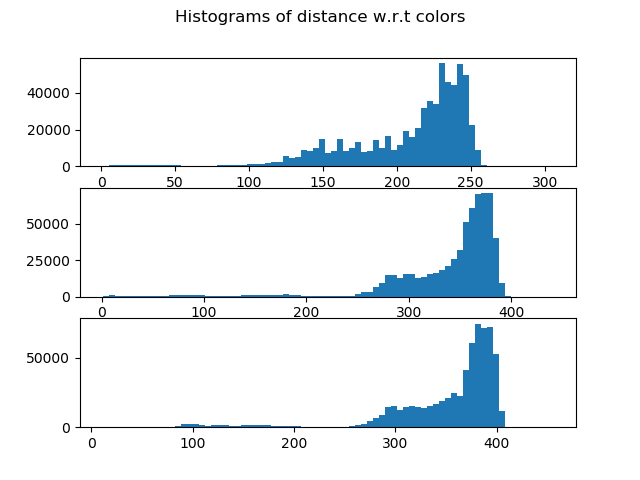

In [5]:
red = np.array([160, 60, 50]).reshape((1,1,3));
blue = np.array([30, 30, 60]).reshape((1,1,3));
green = np.array([35, 80, 20]).reshape((1,1,3));

colors = [red, green, blue]

utils.plot_color_distance_histograms(img_np, colors, bins=75)

### define appropriate distance thresholds to separate color

<IPython.core.display.Javascript object>


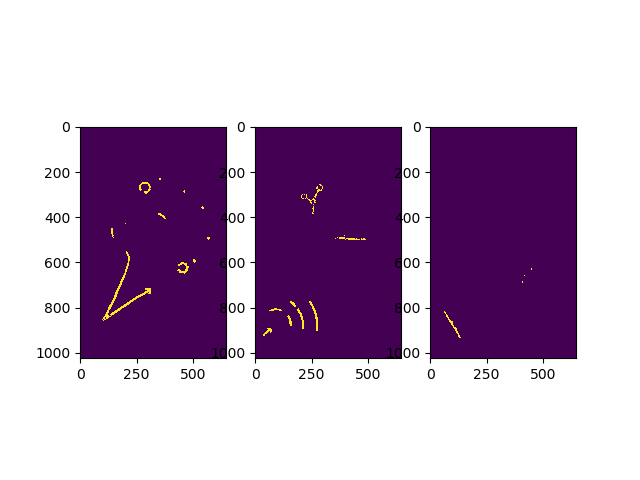

In [6]:
red_threshold = 60
green_threshold = 70
blue_threshold = 60

thresholds = [red_threshold, green_threshold, blue_threshold]

red_img, green_img, blue_img = utils.separate_color_images(img_np, colors, thresholds)

red_img *= (img_np[:,:,0] > img_np[:,:,1]) * (img_np[:,:,0] > img_np[:,:,2]) 
green_img *= (img_np[:,:,1] > img_np[:,:,0]) * (img_np[:,:,1] > img_np[:,:,2]) 
blue_img *= (img_np[:,:,2] > img_np[:,:,0]) * (img_np[:,:,2] > img_np[:,:,1]) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)
ax2.imshow(green_img)
ax3.imshow(blue_img);


### optional TV denoising

<IPython.core.display.Javascript object>


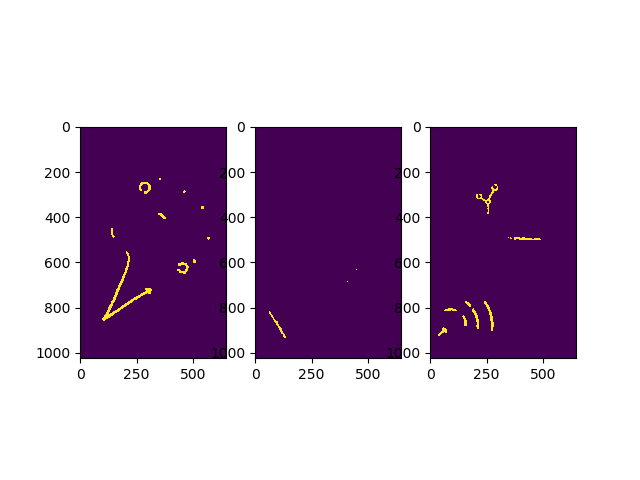

In [7]:
tv_reg, tv_weight, max_ratio = True, 1, 0.3

if tv_reg:    
    red_img, blue_img, green_img = [
        utils.denoise_tv(img, tv_weight=tv_weight, max_ratio=max_ratio) for img in [red_img, blue_img, green_img]
    ]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(red_img)
    ax2.imshow(blue_img)
    ax3.imshow(green_img);

## get strokes

In [8]:
subsample = 3
min_length = 4


color = 'red' if np.random.uniform(0,1) > 0.5 else 'green' 
color_img = red_img if color == 'red' else green_img
color_strokes = utils.get_strokes(color_img, min_length=min_length, subsample=subsample)

<IPython.core.display.Javascript object>


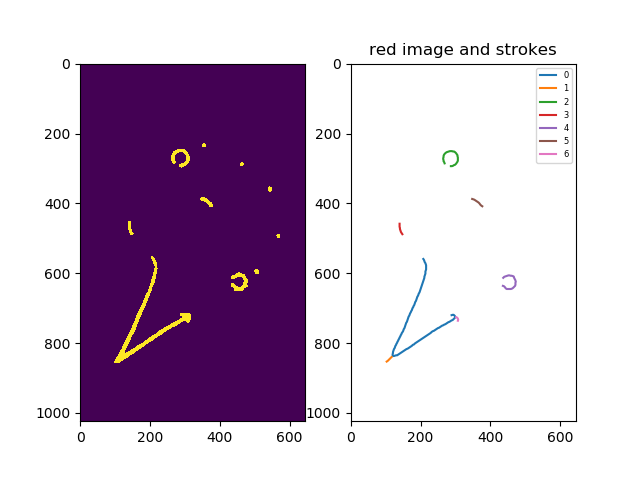

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.title(f'{color} image and strokes')
ax1.imshow(color_img)

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for i, stroke in enumerate(color_strokes):
    stroke = np.array(stroke)
    ax2.plot(stroke[:,1], stroke[:,0], label=str(i))
plt.legend(fontsize=6, markerscale=0.5)

# Stroke completion with SketchRNN

/home/thiry/Desktop/line/sketchRNN/sketchrnn/modelsutils.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(pi.transpose(0, 1).squeeze()).view(len_out, -1, hp.M)


<IPython.core.display.Javascript object>


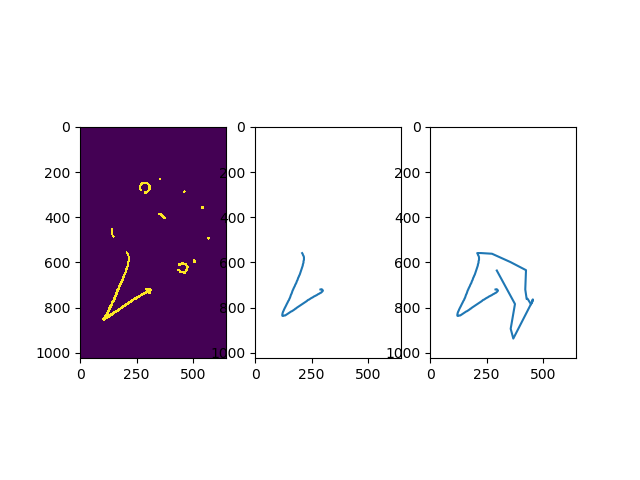

In [10]:
from sketchRNN.sketch_rnn import HParams
import torch
from sketchRNN.complete_img import tina_et_charly_2

replay_tina_and_charly_stroke = False

    
selected_stroke = np.array(color_strokes[np.random.randint(len(color_strokes))])

use_cuda = torch.cuda.is_available()
model_name = 'broccoli_car_cat_20000' # 'sketchrnn_ant.full_20000'
nbr_point_next = 15
sigma = 0.1 

hp_filepath = 'sketchRNN/draw_models/hp_folder/{}.pickle'.format(model_name)
encoder_ckpt = 'sketchRNN/draw_models/encoder_{}.pth'.format(model_name)
decoder_ckpt = 'sketchRNN/draw_models/decoder_{}.pth'.format(model_name)

set_first_point_to_zero = False
rescale_tail = False
stroke_periodized = False


if replay_tina_and_charly_stroke:
    new_strokes = [utils.translate_and_rotate_stroke(selected_stroke, img_np.shape)]
else:
    paint = [selected_stroke]
    new_strokes = tina_et_charly_2(hp_filepath, encoder_ckpt, decoder_ckpt, use_cuda,
                                nbr_point_next, paint, paint, sigma,
                                set_first_point_to_zero=set_first_point_to_zero,
                                rescale_tail=rescale_tail)



fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
aspect = ax1.get_aspect()

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
ax2.plot(selected_stroke[:,1], selected_stroke[:,0]);

ax3.set_xlim(ax1.get_xlim());
ax3.set_ylim(ax1.get_ylim());
ax3.set_aspect(ax1.get_aspect());

for new_stroke in new_strokes:
    ax3.plot(new_stroke[:,1], new_stroke[:,0]);

## define interpolation

<IPython.core.display.Javascript object>


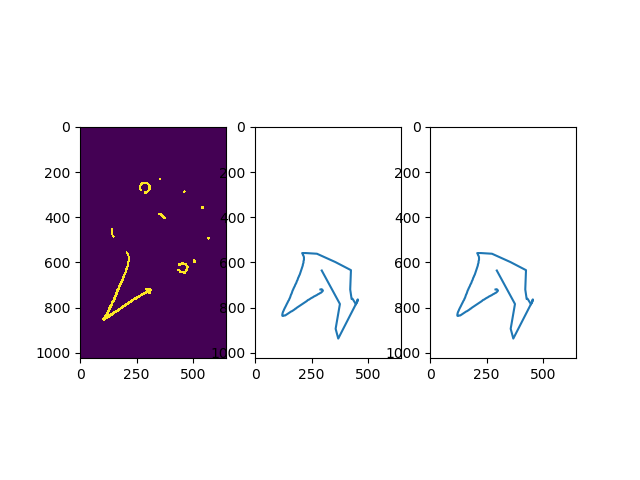

In [11]:
spline_order = 1
n_points_interpolation = 400
do_interpolation = False


interpolated_new_strokes = [
        utils.interpolate_stroke(new_stroke, spline_order=spline_order, n_points=n_points_interpolation) for new_stroke in new_strokes
    ] if do_interpolation else new_strokes

    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(red_img)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
aspect = ax1.get_aspect()

ax2.set_xlim(ax1.get_xlim());
ax2.set_ylim(ax1.get_ylim());
ax2.set_aspect(ax1.get_aspect());
for new_stroke in new_strokes:
    ax2.plot(new_stroke[:,1], new_stroke[:,0]);

ax3.set_xlim(ax1.get_xlim());
ax3.set_ylim(ax1.get_ylim());
ax3.set_aspect(ax1.get_aspect());
for interpolated_new_stroke in interpolated_new_strokes:
    ax3.plot(interpolated_new_stroke[:,1], interpolated_new_stroke[:,0]);
    

### display new stroke on the screen

<IPython.core.display.Javascript object>


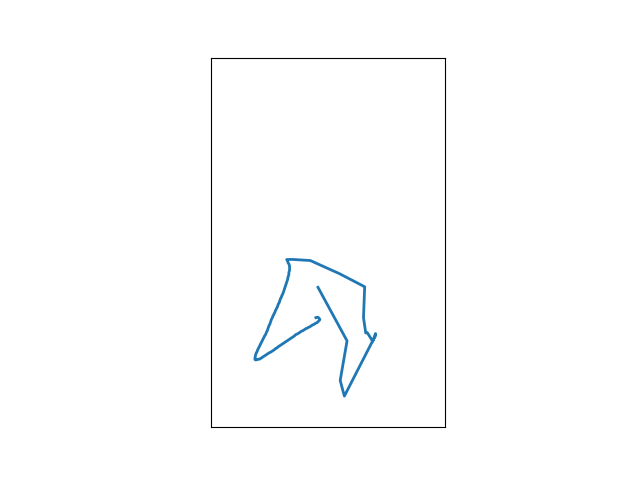

/home/thiry/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/thiry/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
screen_width, screen_height = 1440, 900
image_x, image_y = (396, 41)
image_x_end, image_y_end = (837, 751)

image_width, image_height = image_x_end - image_x , image_y_end - image_y
stroke_width = 2.

utils_display.save_stroke_image(interpolated_new_strokes, xlim, ylim, aspect, screen_height, screen_width, image_y, image_x, image_height, image_width, stroke_width, mask=mask)
utils_display.display_stroke()

# Save variable in a config file

In [13]:
import configparser
config = configparser.ConfigParser()

config['camera'] = {'x_min': x_min, 'y_min': y_min, 'x_max': x_max, 'y_max': y_max, 'path': camera_path.replace('%', 'PERCENT')}


strokes_config = {
    'red': str(red.reshape(-1).tolist()),
    'blue': str(blue.reshape(-1).tolist()),
    'green': str(green.reshape(-1).tolist()),
    'red_threshold': red_threshold,
    'blue_threshold': blue_threshold,
    'green_threshold': green_threshold,
    'subsample': subsample,
    'min_length': min_length,
}


config['display'] = {
    'screen_width': screen_width,
    'screen_height': screen_height,
    'image_x': image_x,
    'image_y': image_y,
    'image_width': image_width,
    'image_height': image_height,
    'stroke_width': stroke_width,
}


config['sketchRNN'] = {
    'hp_filepath': hp_filepath,
    'encoder_ckpt': encoder_ckpt,
    'decoder_ckpt': decoder_ckpt,
    'nbr_point_next': nbr_point_next,
    'sigma': sigma,
    'set_first_point_to_zero': set_first_point_to_zero,
    'rescale_tail': rescale_tail,
    'spline_order': spline_order,
    'n_points_interpolation': n_points_interpolation
}


config_filename = 'config_example.ini'
with open(config_filename, 'w') as configfile:
    config.write(configfile)